In [9]:
import tensorflow_datasets as tfds

# Download the subword encoded pretokenized dataset
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

# Get the tokenizer
tokenizer = info.features['text'].encoder

In [10]:
import json

# Load the JSON file
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [11]:
training_size = 20000
# Split the sentences
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Split the labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [12]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Hyperparameters
vocab_size = 10000
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generatve and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

#Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

print('training_padded',training_padded.shape)
print('testing_padded',testing_padded.shape)
print('training_labels',training_labels.shape)
print('testing_labels',testing_labels.shape)

training_padded (20000, 120)
testing_padded (6709, 120)
training_labels (20000,)
testing_labels (6709,)


In [13]:
import tensorflow as tf

# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d_2 (Conv1D)           (None, 116, 128)          10368     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 6)                 774       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
________________________________________________

In [14]:
NUM_EPOCHS = 10

# Train the model
history_conv = model_conv.fit(training_padded, training_labels, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels))

Epoch 1/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4403 - accuracy: 0.7855 - val_loss: 0.3603 - val_accuracy: 0.8427
Epoch 2/10
107/625 [====>.........................] - ETA: 0s - loss: 0.2100 - accuracy: 0.9206

2024-01-29 21:28:39.686230: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 357.29MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-01-29 21:28:39.686359: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 357.29MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


625/625 [==============================] - 2s 3ms/step - loss: 0.2262 - accuracy: 0.9108 - val_loss: 0.3630 - val_accuracy: 0.8456
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.1135 - accuracy: 0.9618 - val_loss: 0.4559 - val_accuracy: 0.8402
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.0481 - accuracy: 0.9860 - val_loss: 0.5925 - val_accuracy: 0.8328
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0190 - accuracy: 0.9951 - val_loss: 0.6958 - val_accuracy: 0.8356
Epoch 6/10
625/625 [==============================] - 2s 2ms/step - loss: 0.0073 - accuracy: 0.9983 - val_loss: 0.7978 - val_accuracy: 0.8332
Epoch 7/10
625/625 [==============================] - 1s 2ms/step - loss: 0.0029 - accuracy: 0.9995 - val_loss: 0.8706 - val_accuracy: 0.8331
Epoch 8/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.9504 - val_accuracy: 0.8344
Epoch 9/10
625/62

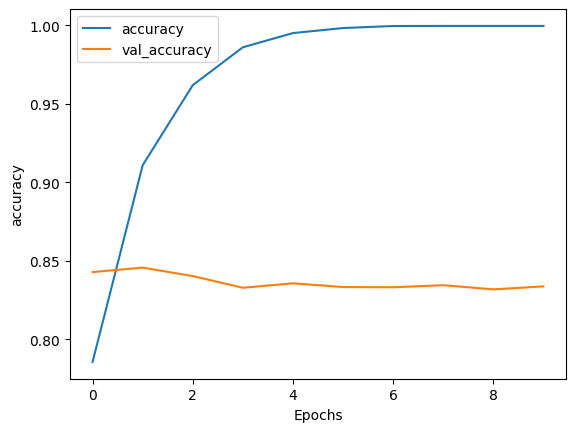

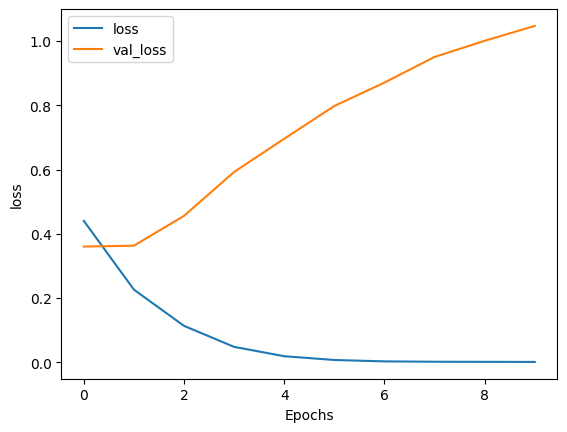

In [17]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')